In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import AutoModel, AutoConfig
from torch.utils.data import TensorDataset, DataLoader
from BESTRq_classes.conformer import ConformerEncoder
from BESTRq_classes.BESTRq import BestRqFramework, RandomProjectionQuantizer

In [30]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [96]:
def pretrain(trainloader, validloader, model, epochs=10, lr=1e-3, device = 'cpu'):

    optimizer = optim.Adam(model.encoder.parameters(), lr=lr)
    loss_function = nn.MSELoss(reduction='mean')

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    valid_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch
    train_accuracies = []    # Pour sauvegarder l'accuracy de validation à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0
        correct = 0
        total = 0

        # Training phase
        model.train()
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            inputs = inputs.view(1, -1, 600).to(device)
            encoder_outs, labels = model(inputs, masking = True)
            loss = loss_function(encoder_outs.view(1, -1, 1), labels.float().view(1,-1, 1))
            loss.backward()
            optimizer.step()
            # Compute accuracy
            predicted = th.round(encoder_outs)
            total += labels.size(1)
            correct += (predicted == labels.view_as(predicted)).sum().item()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)
        # Calculate validation accuracy
        train_accuracy = correct / total
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs = inputs.view(1, -1, 600).to(device)
                encoder_outs, labels = model(inputs, masking = False)
                loss = loss_function(encoder_outs.view(1, -1, 1), labels.float().view(1, -1, 1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.round(encoder_outs)
                total += labels.size(1)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate validation accuracy
            valid_accuracy = correct / total
            valid_accuracies.append(valid_accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Training Accuracy: {train_accuracy}, Validation Accuracy: {valid_accuracy}")

    return train_losses, valid_losses, train_accuracies, valid_accuracies

In [4]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [5]:
class GRUPredictor(nn.Module):
    """GRUPredictor is a recurrent model. It takes as input a vector and predict
    the next one given past observations."""
    def __init__(self, input_dim=600, hidden_dim=50, nstack = 3, dropout=0):
        super(GRUPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout
        self.gru = nn.GRU(input_size=input_dim, hidden_size = hidden_dim,  num_layers = nstack)
        self.linear = nn.Linear(in_features = hidden_dim, out_features = 200)
        self.drop = nn.Dropout(p = dropout)
    def init_hidden(self, bsz):
        # This function is given: understand it.
        self.h = th.zeros(self.nstack, bsz, self.hidden_dim)

    def forward(self, inputs, h0=None):
        if h0 == None:
          h0 = self.init_hidden(inputs.shape[0])
        hidden, h0 = self.gru(inputs, h0)
        out = self.drop(hidden)
        out = self.linear(hidden)
        return out

In [99]:
class AttentionLSTM(nn.Module):
    def __init__(self, input_dim=600, hidden_dim=100, nstack=3, dropout=0):
        super(AttentionLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.nstack = nstack
        self.dropout = dropout

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=nstack)

        # Linear layers for attention
        self.attention_linear = nn.Linear(hidden_dim, 1)
        self.context_linear = nn.Linear(hidden_dim, hidden_dim)

        # Final linear layer
        self.linear = nn.Linear(hidden_dim, 200)

        # Dropout layer
        self.drop = nn.Dropout(p=dropout)

    def init_hidden(self, bsz):
        # Initialize hidden state for LSTM
        return (th.zeros(self.nstack, bsz, self.hidden_dim),
            th.zeros(self.nstack, bsz, self.hidden_dim))


    def forward(self, inputs, h0=None):
        if h0 is None:
            (h0, c0) = self.init_hidden(inputs.size(1))  # Use size(1) to get the batch size

        h0, c0 = h0.to(device), c0.to(device)

        # Transpose inputs to match the expected dimensions
        inputs = inputs

        # LSTM forward pass
        lstm_output, _ = self.lstm(inputs, (h0, c0))

        # Compute attention weights
        attention_weights = F.softmax(self.attention_linear(lstm_output), dim=0)

        # Apply attention to LSTM output
        attention_applied = th.sum(attention_weights * lstm_output, dim=0)

        # Compute context vector
        context = self.context_linear(attention_applied)

        # Apply dropout
        out = self.drop(context)

        # Final linear layer
        out = self.linear(out)

        return out


In [32]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 20,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched)
results

tensor([[11,  3, 10,  ..., 16,  6,  3]])

Text(0.5, 1.0, 'Visualisation du masque')

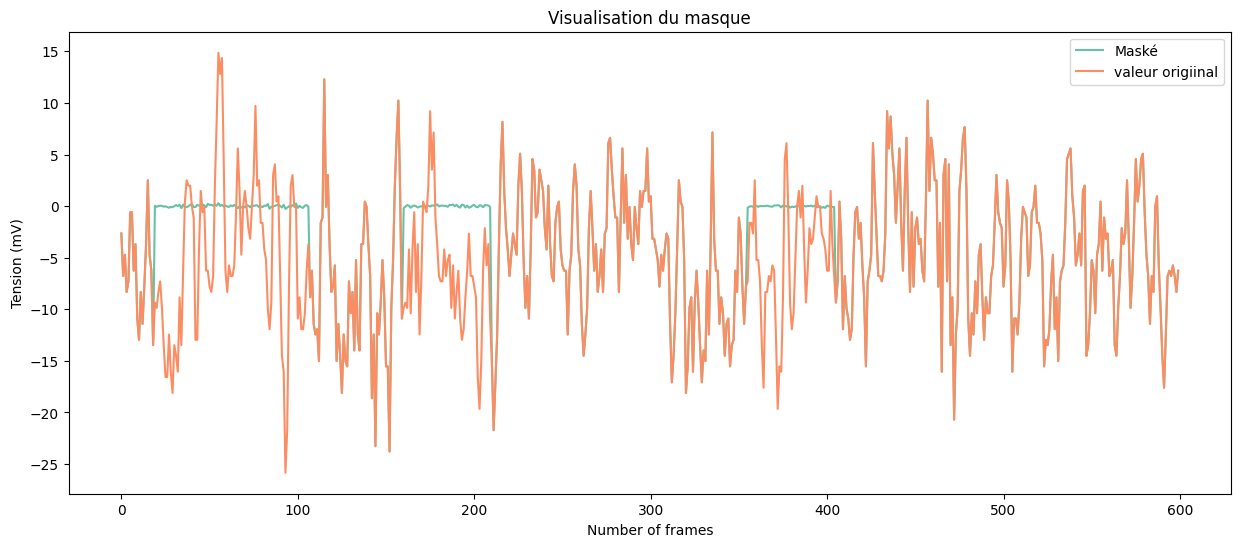

In [85]:
#Viz of the mask
model = BestRqFramework(encoder= AttentionLSTM(dropout = 0.1, hidden_dim = 150),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

masked_values,_ = model.masking(inputs)



plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].cpu().detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].cpu().detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')

In [5]:
conformer_model = ConformerEncoder(input_size = 600, num_blocks = 3, kernel_size = 3, num_heads = 4).to(device)

In [97]:
device = th.device('mps')

model = BestRqFramework(encoder= AttentionLSTM(dropout= 0.1, hidden_dim = 200),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=0.2,
                        batch_size=200,
                        device = device)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs, masking = False)


Tried doing with hidden_dim = 200, mask_prob = 0.3, epochs = 100 but signs of overfitting appeared for about 30 epochs

In [98]:
dataset_t = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(dataset_t, batch_size= 400, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 400, shuffle=True)
train_losses, valid_losses, train_accuracies, valid_accuracies = pretrain(trainloader= train_loader, validloader= valid_loader, model = model, epochs= 60, device = device, lr = 1e-3)

  2%|▏         | 1/60 [00:28<28:02, 28.52s/it]

Epoch 1/60, Train Loss: 6.349975111809644, Validation Loss: 4.2188960873350805, Training Accuracy: 0.17290263927952498, Validation Accuracy: 0.25415725723670707


  3%|▎         | 2/60 [00:52<24:47, 25.64s/it]

Epoch 2/60, Train Loss: 4.174076760898937, Validation Loss: 3.454663948136933, Training Accuracy: 0.2907355322594392, Validation Accuracy: 0.3438205707246972


  5%|▌         | 3/60 [01:16<23:45, 25.02s/it]

Epoch 3/60, Train Loss: 3.5345838497985493, Validation Loss: 3.2562405381883894, Training Accuracy: 0.3569249126395636, Validation Accuracy: 0.302709915828372


  7%|▋         | 4/60 [01:45<25:00, 26.80s/it]

Epoch 4/60, Train Loss: 3.100953330776908, Validation Loss: 3.0219058211968868, Training Accuracy: 0.412613994715759, Validation Accuracy: 0.4522685280229932


  8%|▊         | 5/60 [02:11<24:00, 26.19s/it]

Epoch 5/60, Train Loss: 2.820481298186562, Validation Loss: 2.9962315510730355, Training Accuracy: 0.44990482684167166, Validation Accuracy: 0.4293779511393964


 10%|█         | 6/60 [02:35<23:02, 25.60s/it]

Epoch 6/60, Train Loss: 2.5489667610688644, Validation Loss: 3.049198009529892, Training Accuracy: 0.4903093837893122, Validation Accuracy: 0.4390268938616301


 12%|█▏        | 7/60 [02:59<22:10, 25.10s/it]

Epoch 7/60, Train Loss: 2.405561892281879, Validation Loss: 3.0712772680788625, Training Accuracy: 0.5129577544816614, Validation Accuracy: 0.4764422089919934


 13%|█▎        | 8/60 [03:24<21:36, 24.94s/it]

Epoch 8/60, Train Loss: 2.2859012335538864, Validation Loss: 3.005533904445415, Training Accuracy: 0.5286741100599449, Validation Accuracy: 0.529768014781359


 15%|█▌        | 9/60 [03:48<20:57, 24.67s/it]

Epoch 9/60, Train Loss: 2.183364855430343, Validation Loss: 3.079255303558038, Training Accuracy: 0.551731583283616, Validation Accuracy: 0.49455963867788955


 17%|█▋        | 10/60 [04:12<20:29, 24.59s/it]

Epoch 10/60, Train Loss: 2.1190152333541348, Validation Loss: 3.0327832212253494, Training Accuracy: 0.5603000085229694, Validation Accuracy: 0.5610244303017861


 18%|█▊        | 11/60 [04:37<20:11, 24.73s/it]

Epoch 11/60, Train Loss: 2.0617858480323443, Validation Loss: 3.0673937748889535, Training Accuracy: 0.5712662291542373, Validation Accuracy: 0.5569698213919113


 20%|██        | 12/60 [05:07<21:01, 26.28s/it]

Epoch 12/60, Train Loss: 1.986212219568816, Validation Loss: 3.1344147263741005, Training Accuracy: 0.5875735106110969, Validation Accuracy: 0.539160336686512


 22%|██▏       | 13/60 [05:42<22:39, 28.94s/it]

Epoch 13/60, Train Loss: 1.951949336312034, Validation Loss: 3.1379397499318027, Training Accuracy: 0.5954828262166539, Validation Accuracy: 0.5226339560665161


 23%|██▎       | 14/60 [06:14<22:46, 29.70s/it]

Epoch 14/60, Train Loss: 1.9498111967336047, Validation Loss: 3.0864668719622554, Training Accuracy: 0.5984942754055513, Validation Accuracy: 0.5720591254362554


 25%|██▌       | 15/60 [06:47<23:13, 30.97s/it]

Epoch 15/60, Train Loss: 1.892604144594886, Validation Loss: 3.1508378787916533, Training Accuracy: 0.6112048637745391, Validation Accuracy: 0.5933073290905359


 27%|██▋       | 16/60 [07:14<21:37, 29.49s/it]

Epoch 16/60, Train Loss: 1.8369563289664008, Validation Loss: 3.2103306565965926, Training Accuracy: 0.6194891900338078, Validation Accuracy: 0.5690309997947034


 28%|██▊       | 17/60 [07:40<20:24, 28.49s/it]

Epoch 17/60, Train Loss: 1.8343959385698492, Validation Loss: 3.2129839975006727, Training Accuracy: 0.6233131623057473, Validation Accuracy: 0.5624101827140218


 30%|███       | 18/60 [08:05<19:17, 27.56s/it]

Epoch 18/60, Train Loss: 1.7934154184027151, Validation Loss: 3.268613645008632, Training Accuracy: 0.6309667888292281, Validation Accuracy: 0.5814001231779922


 32%|███▏      | 19/60 [08:33<18:51, 27.60s/it]

Epoch 19/60, Train Loss: 1.8084697316993366, Validation Loss: 3.2946949053783805, Training Accuracy: 0.6332793545271173, Validation Accuracy: 0.5882775610757545


 33%|███▎      | 20/60 [08:58<17:58, 26.96s/it]

Epoch 20/60, Train Loss: 1.792723330178044, Validation Loss: 3.3936581952231273, Training Accuracy: 0.6386090513935055, Validation Accuracy: 0.6013652227468692


 35%|███▌      | 21/60 [09:24<17:15, 26.54s/it]

Epoch 21/60, Train Loss: 1.7466150350191376, Validation Loss: 3.217095540494335, Training Accuracy: 0.6480752294099265, Validation Accuracy: 0.597515910490659


 37%|███▋      | 22/60 [09:49<16:27, 25.99s/it]

Epoch 22/60, Train Loss: 1.7153182314200834, Validation Loss: 3.2865958262463004, Training Accuracy: 0.6494673144123413, Validation Accuracy: 0.5888934510367481


 38%|███▊      | 23/60 [10:14<15:57, 25.88s/it]

Epoch 23/60, Train Loss: 1.6865266530351206, Validation Loss: 3.2371062405255375, Training Accuracy: 0.6552345237080599, Validation Accuracy: 0.6061383699445699


 40%|████      | 24/60 [10:41<15:42, 26.19s/it]

Epoch 24/60, Train Loss: 1.7186995954676108, Validation Loss: 3.2718276393656827, Training Accuracy: 0.6563652376487968, Validation Accuracy: 0.5965407513857525


 42%|████▏     | 25/60 [11:05<14:58, 25.67s/it]

Epoch 25/60, Train Loss: 1.6617810531096024, Validation Loss: 3.23860333890331, Training Accuracy: 0.6640472740702861, Validation Accuracy: 0.6053171833299117


 43%|████▎     | 26/60 [11:30<14:22, 25.36s/it]

Epoch 26/60, Train Loss: 1.6495741021904078, Validation Loss: 3.453561476298741, Training Accuracy: 0.6684167163839881, Validation Accuracy: 0.620098542393759


 45%|████▌     | 27/60 [11:56<14:00, 25.47s/it]

Epoch 27/60, Train Loss: 1.6739257421005855, Validation Loss: 3.4294514704723746, Training Accuracy: 0.6648200232961163, Validation Accuracy: 0.6202011907205912


 47%|████▋     | 28/60 [12:23<13:53, 26.06s/it]

Epoch 28/60, Train Loss: 1.6131942144849083, Validation Loss: 3.3651284879567673, Training Accuracy: 0.676456717520384, Validation Accuracy: 0.6358037363990967


 48%|████▊     | 29/60 [12:51<13:43, 26.55s/it]

Epoch 29/60, Train Loss: 1.6131188972429795, Validation Loss: 3.2844399408418306, Training Accuracy: 0.6763203500099435, Validation Accuracy: 0.6235372613426401


 50%|█████     | 30/60 [13:16<13:03, 26.10s/it]

Epoch 30/60, Train Loss: 1.6069142692468383, Validation Loss: 3.3864402819652946, Training Accuracy: 0.6797068098525526, Validation Accuracy: 0.6185074933278587


 52%|█████▏    | 31/60 [13:43<12:41, 26.25s/it]

Epoch 31/60, Train Loss: 1.630526165393266, Validation Loss: 3.320860225327161, Training Accuracy: 0.6800477286286543, Validation Accuracy: 0.5684151098337097


 53%|█████▎    | 32/60 [14:10<12:27, 26.69s/it]

Epoch 32/60, Train Loss: 1.5583836632696064, Validation Loss: 3.3581080631333955, Training Accuracy: 0.6869058780078979, Validation Accuracy: 0.6397556969821392


 55%|█████▌    | 33/60 [14:37<12:01, 26.73s/it]

Epoch 33/60, Train Loss: 1.6120139861648732, Validation Loss: 3.31522274017334, Training Accuracy: 0.686701326742237, Validation Accuracy: 0.6324163416136317


 57%|█████▋    | 34/60 [15:04<11:37, 26.84s/it]

Epoch 34/60, Train Loss: 1.5685647269541567, Validation Loss: 3.2841050332906296, Training Accuracy: 0.6878547686013807, Validation Accuracy: 0.6425785259700267


 58%|█████▊    | 35/60 [15:38<12:03, 28.95s/it]

Epoch 35/60, Train Loss: 1.5663706159049815, Validation Loss: 3.389298049771056, Training Accuracy: 0.693536748203074, Validation Accuracy: 0.6500205296653665


 60%|██████    | 36/60 [16:03<11:08, 27.86s/it]

Epoch 36/60, Train Loss: 1.53177624006163, Validation Loss: 3.33450300352914, Training Accuracy: 0.6992130458251655, Validation Accuracy: 0.6357524122356806


 62%|██████▏   | 37/60 [16:29<10:22, 27.05s/it]

Epoch 37/60, Train Loss: 1.509060675041242, Validation Loss: 3.4289736358486875, Training Accuracy: 0.7023722264837069, Validation Accuracy: 0.6506364196263601


 63%|██████▎   | 38/60 [16:56<09:55, 27.05s/it]

Epoch 38/60, Train Loss: 1.5159166287292134, Validation Loss: 3.3840927396501814, Training Accuracy: 0.7064575698173243, Validation Accuracy: 0.6432457400944365


 65%|██████▌   | 39/60 [17:23<09:31, 27.22s/it]

Epoch 39/60, Train Loss: 1.5147480994462967, Validation Loss: 3.447858606066023, Training Accuracy: 0.7079235205545612, Validation Accuracy: 0.6398583453089715


 67%|██████▋   | 40/60 [17:50<08:59, 26.99s/it]

Epoch 40/60, Train Loss: 1.5045195732604373, Validation Loss: 3.4035320719894098, Training Accuracy: 0.7099008494559504, Validation Accuracy: 0.6546397043728187


 68%|██████▊   | 41/60 [18:14<08:18, 26.23s/it]

Epoch 41/60, Train Loss: 1.4830019101500511, Validation Loss: 3.3455512766935387, Training Accuracy: 0.7150373590158812, Validation Accuracy: 0.6472490248408951


 70%|███████   | 42/60 [18:41<07:52, 26.26s/it]

Epoch 42/60, Train Loss: 1.4981885793534193, Validation Loss: 3.478526855001644, Training Accuracy: 0.7132191255433393, Validation Accuracy: 0.6619277355779101


 72%|███████▏  | 43/60 [19:07<07:25, 26.23s/it]

Epoch 43/60, Train Loss: 1.4929965687069027, Validation Loss: 3.4456561828146177, Training Accuracy: 0.7145543907497373, Validation Accuracy: 0.6547936768630671


 73%|███████▎  | 44/60 [19:31<06:50, 25.68s/it]

Epoch 44/60, Train Loss: 1.498945152759552, Validation Loss: 3.369401031610917, Training Accuracy: 0.7153953237307878, Validation Accuracy: 0.6477109423116403


 75%|███████▌  | 45/60 [19:56<06:22, 25.48s/it]

Epoch 45/60, Train Loss: 1.5046379350803114, Validation Loss: 3.4911693018309924, Training Accuracy: 0.7152135003835336, Validation Accuracy: 0.6609525764730035


 77%|███████▋  | 46/60 [20:20<05:50, 25.06s/it]

Epoch 46/60, Train Loss: 1.4616528796878727, Validation Loss: 3.3322412821711325, Training Accuracy: 0.7213045825165487, Validation Accuracy: 0.644220899199343


 78%|███████▊  | 47/60 [20:45<05:24, 24.96s/it]

Epoch 47/60, Train Loss: 1.4623332034457814, Validation Loss: 3.369556645957791, Training Accuracy: 0.7243160317054462, Validation Accuracy: 0.6550502976801478


 80%|████████  | 48/60 [21:09<04:55, 24.62s/it]

Epoch 48/60, Train Loss: 1.459053354778073, Validation Loss: 3.462669557454635, Training Accuracy: 0.7259808517287423, Validation Accuracy: 0.676965715458838


 82%|████████▏ | 49/60 [21:33<04:30, 24.58s/it]

Epoch 49/60, Train Loss: 1.4446835301139138, Validation Loss: 3.4895663942609514, Training Accuracy: 0.7258274382794966, Validation Accuracy: 0.6759905563539315


 83%|████████▎ | 50/60 [21:58<04:05, 24.56s/it]

Epoch 50/60, Train Loss: 1.4543395734646103, Validation Loss: 3.388341947477691, Training Accuracy: 0.7275149862211995, Validation Accuracy: 0.6593102032436872


 85%|████████▌ | 51/60 [22:22<03:40, 24.46s/it]

Epoch 51/60, Train Loss: 1.4672421315854245, Validation Loss: 3.4602115008295797, Training Accuracy: 0.7259467598511321, Validation Accuracy: 0.6544344077191542


 87%|████████▋ | 52/60 [22:46<03:15, 24.47s/it]

Epoch 52/60, Train Loss: 1.4573772538792003, Validation Loss: 3.449297267563489, Training Accuracy: 0.7303275661240376, Validation Accuracy: 0.6669061794292753


 88%|████████▊ | 53/60 [23:10<02:49, 24.25s/it]

Epoch 53/60, Train Loss: 1.4352515459060669, Validation Loss: 3.3138835576115824, Training Accuracy: 0.7344583652944686, Validation Accuracy: 0.6674707452268528


 90%|█████████ | 54/60 [23:35<02:25, 24.27s/it]

Epoch 54/60, Train Loss: 1.4232868791981177, Validation Loss: 3.4028335347467538, Training Accuracy: 0.7338617574362908, Validation Accuracy: 0.6537671935947444


 92%|█████████▏| 55/60 [24:00<02:02, 24.52s/it]

Epoch 55/60, Train Loss: 1.4483809979124502, Validation Loss: 3.353941873628266, Training Accuracy: 0.732765135373164, Validation Accuracy: 0.6508930404434408


 93%|█████████▎| 56/60 [24:24<01:37, 24.48s/it]

Epoch 56/60, Train Loss: 1.4150314662944188, Validation Loss: 3.4103330981974698, Training Accuracy: 0.7372936731157135, Validation Accuracy: 0.6675733935536851


 95%|█████████▌| 57/60 [24:48<01:13, 24.41s/it]

Epoch 57/60, Train Loss: 1.413703216612339, Validation Loss: 3.347835900832196, Training Accuracy: 0.7382596096480014, Validation Accuracy: 0.6670601519195237


 97%|█████████▋| 58/60 [25:13<00:48, 24.37s/it]

Epoch 58/60, Train Loss: 1.4038099549033425, Validation Loss: 3.3899522022325166, Training Accuracy: 0.741969942327907, Validation Accuracy: 0.6790700061588996


 98%|█████████▊| 59/60 [25:37<00:24, 24.49s/it]

Epoch 59/60, Train Loss: 1.4199968163262715, Validation Loss: 3.433579697900889, Training Accuracy: 0.7387709878121538, Validation Accuracy: 0.6532026277971669


100%|██████████| 60/60 [26:03<00:00, 26.05s/it]

Epoch 60/60, Train Loss: 1.4209473131732506, Validation Loss: 3.478553587076615, Training Accuracy: 0.7414017443677378, Validation Accuracy: 0.6787620611784028


Text(0.5, 0.98, 'Attention-LSTM')

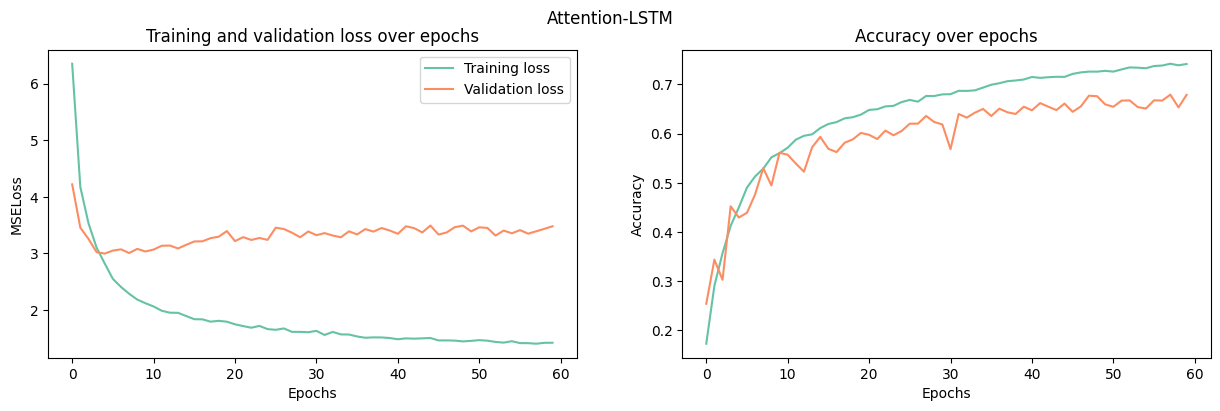

In [100]:
sns.set_palette("Set2")
fig, ax = plt.subplots(1,2, figsize = (15, 4))
ax[0].plot(train_losses, label = 'Training loss')
ax[0].plot(valid_losses, label = 'Validation loss')
ax[1].plot(train_accuracies, label ='Training Accuracy')
ax[1].plot(valid_accuracies, label ='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Training and validation loss over epochs')
ax[1].set_title('Accuracy over epochs')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('MSELoss')
ax[1].set_ylabel('Accuracy')
fig.suptitle('Attention-LSTM')